# Renovation Explorer: Off-the-fly model

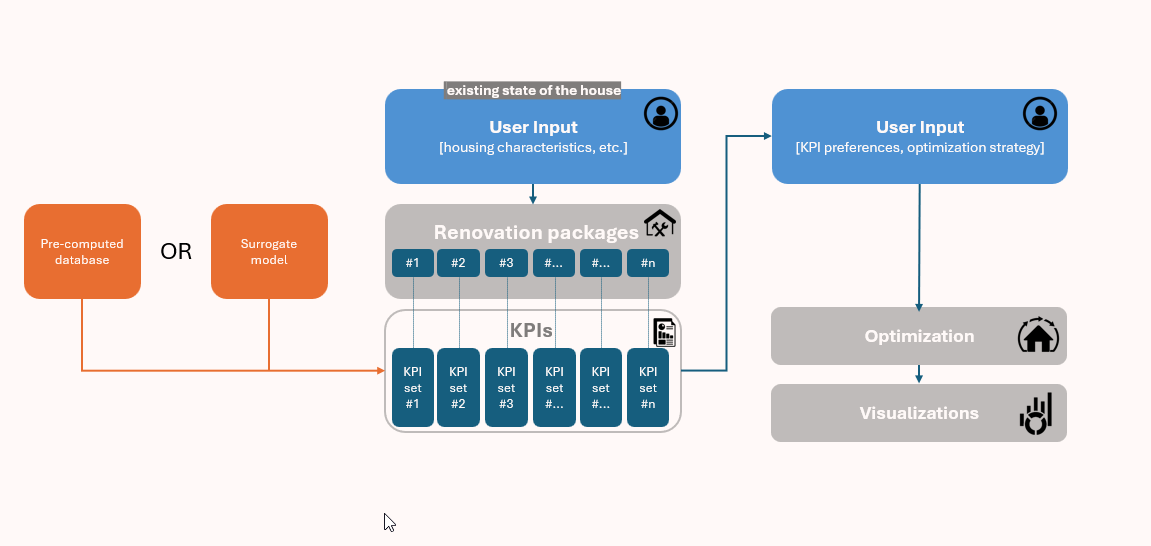

In [ ]:
from ast import literal_eval
from pathlib import Path
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output


from renovexpy.off_the_fly import query_surrogate_models
from renovexpy.optimization import find_optimal_packages, pareto_optimization
from renovexpy.renovation import get_rm_options, renovation_measures

pd.set_option("display.max_columns", None)


def make_widget_menu(D_options: dict, output_var):
    D_widgets = {}
    for param, options in D_options.items():
        if isinstance(param, tuple):
            param = str(param)
        # Use label for param
        param = param_labels.get(param, param)
        if isinstance(options, list):
            if "insulation" in param:
                options = [
                    [value_labels.get(mat, mat), pos, R] for mat, pos, R in options
                ]
            options = [str(opt) for opt in options]  # Ensure all options are strings
            # Use labels for options
            options = [value_labels.get(opt, opt) for opt in options]
            D_widgets[param] = widgets.Dropdown(
                options=options,
                description=param,
                value=options[0],  # default to first option
                style={"description_width": "initial"},
                layout=widgets.Layout(width="500px"),
            )
        elif isinstance(options, tuple) and len(options) == 2:
            # Assuming tuple is a range (min, max). Make a text entry
            D_widgets[param] = widgets.FloatSlider(
                value=(options[0] + options[1]) / 2,  # default to midpoint
                min=options[0],
                max=options[1],
                step=0.01,
                description=param,
                style={"description_width": "initial"},
            )

    # ─── 2. Create the Submit button and output area ────────────────────────────
    submit_btn = widgets.Button(description="Submit")
    # output_area = widgets.Output()

    def on_submit(btn):
        inv_param_labels = {v: k for k, v in param_labels.items()}
        inv_value_labels = {v: k for k, v in value_labels.items()}
        for col, w in D_widgets.items():
            # Revert to original param name
            col = inv_param_labels.get(col, col)
            if col.startswith("("):
                col = literal_eval(col)
            # Revert to original param name
            value = inv_value_labels.get(w.value, w.value)
            try:
                value = literal_eval(value)
                if isinstance(value, list) and len(value) > 0:
                    value[0] = inv_value_labels.get(value[0], value[0])
                output_var[col] = value
            except ValueError:
                output_var[col] = value
        return

    submit_btn.on_click(on_submit)

    # ─── 3. Display everything ───────────────────────────────────────────────────
    # You can arrange in a VBox, HBox, Grid, etc.
    ui = widgets.VBox(list(D_widgets.values()) + [submit_btn])
    display(ui)
    return


def clean_df_opt(df_opt):
    for surf_type in ["wall", "roof", "floor"]:
        cols = [f"{surf_type}_insulation_{k}" for k in range(3)]
        cols = [col for col in df_opt.columns if col in cols]
        df_opt[surf_type + "_insulation"] = df_opt[cols].apply(
            lambda row: str(list(row)), axis=1
        )
        df_opt = df_opt.drop(columns=cols)
    return df_opt


value_labels = {
    "S": "South",
    "W": "West",
    "VR": "Standard gas boiler",
    "HR107": "High-efficiency gas boiler",
    "HP 5kW": "Heat pump 5kW",
    "HP 7kW": "Heat pump 7kW",
    "HP 10kW": "Heat pump 10kW",
    "HP 3kW Intergas + HR107 Parallel": "Hybrid heat pump 5kW",
    "[]": "None",
    "['SouthWall_0F', 'SouthWall_1FS']": "South facade",
    "['SouthWall_0F', 'SouthWall_1FS', 'NorthWall_0F', 'NorthWall_1FN']": "South + North facades",
    # PV panels
    "11": "11 (Half of roof)",
    "22": "22 (Whole roof)",
    # Insulation materials
    "Rockwool": "Mineral wool",
    "Icynene": "Polyurethane foam",
    "['Mineral wool', 'External', 0]": "No insulation",
    "['Rockwool', 'External', 0]": "No insulation ",
}
param_labels = {
    "building_position": "Building position",
    "building_orientation": "Building orientation",
    "floor_type": "Floor type",
    "WWR": "Window-to-wall ratio",
    "floor_insulation": "Floor insulation [material, position, R-value]",
    "roof_insulation": "Roof insulation [material, position, R-value]",
    "wall_insulation": "Wall insulation [material, position, R-value]",
    "('glazing', 'window_frame')": "Glazing and window frame",
    "heating_system": "Heating system",
    "vent_type": "Ventilation system",
    "N_pv": "Number of PV panels",
    "airtightness": "Airtightness",
    "shaded_surfaces": "Shading",
    "radiator_area": "Radiator area [m²]",
}

### 1. Define pre-renovation configuration

In [2]:
pre_renov_config = {
    "building_type": "terraced_house",
    "occupant_activity_level": "mid",
    "lighting_power_per_area": 1,
    "equipment_power_per_area": 1,
    "shading_position": "External",
}
hc_options = {
    "building_position": ["middle", "corner"],
    "building_orientation": ["S", "W"],
    "floor_type": ["Wood", "Concrete"],
    "WWR": (0.2, 0.8),
}
make_widget_menu(hc_options, pre_renov_config)

In [15]:
rm_options = get_rm_options(renovation_measures, pre_renov_config["floor_type"])
make_widget_menu(rm_options, pre_renov_config)

### 2. Simulate all applicable renovation packages

In [4]:
unknown_params = {
    "n_occupants": (1, 2, 4),
    "heated_zones": (
        ["0F"],
        ["0F", "1FS"],
        ["0F", "1FS", "1FN"],
        ["0F", "1FS", "2F"],
        ["0F", "1FS", "1FN", "2F"],
    ),
    "heating_setpoint": (
        "Always_21",
        "N17_D19",
        "N15_D19",
        "N17_D20",
        "N15_M17_D16_E19",
    ),
    "window_vent_profile": (1, 2, 3, 4),
    "use_vent_grilles": (True, False),
    "mech_vent_profile": (1, 2, 3),
    "shading_profile": (1, 2, 3, 4),
    "epw_file": ("DeBilt_2000", "DeBilt_2050", "DeBilt_2100"),
}

df = query_surrogate_models(
    pre_renov_config,
    unknown_params,
    N_scenarios=8,
    replace_window_frames=False,
    max_rm_per_package=5,
)

Simulated 92054 renovation packages across 8 scenarios.


### 3. Find optimal renovation packages

In [5]:
optimization_params = {}

kpis = [
    # Energy
    "Heating demand [kWh]",
    "Electricity OPP [kW]",
    # Cost
    "Renovation cost [€]",
    "TCO over 30 years [€]",
    "Payback period [year]",
    # CO2
    "CO2 emissions [kgCO2]",
    "CO2 reduction per euro [kgCO2/€]",
    # Comfort
    "Overheating [h]",
    "CO2 excess [h]",
]

# Widgets
kpi_selector = widgets.SelectMultiple(
    options=kpis, description="KPIs:", layout=widgets.Layout(width="500px"), rows=10
)
robustness_selector = widgets.Dropdown(
    options=["mean", "max_regret"],
    description="Robustness indicator",
    style={"description_width": "250px"},
    layout=widgets.Layout(width="500px"),
)
n_top_input = widgets.Text(
    description="Number of optimal packages:",
    placeholder="Enter number",
    value="10",
    layout=widgets.Layout(width="500px"),
    style={"description_width": "250px"},
)
submit_button = widgets.Button(description="Submit", button_style="success")
output = widgets.Output()

# Create and store all KPI text fields up front
kpi_text_fields = {
    kpi: widgets.Text(
        description=kpi + ":",
        placeholder="Enter requirement (optional)",
        layout=widgets.Layout(width="500px"),
        style={"description_width": "250px"},
    )  # truncate label if long
    for kpi in kpis
}
kpi_text_container = widgets.VBox(list(kpi_text_fields.values()))


# Submission handler
def on_submit_clicked(b):
    global optimization_params
    optimization_params = {
        "kpis": list(kpi_selector.value),
        "requirements": {
            kpi: float(field.value)
            for kpi, field in kpi_text_fields.items()
            if field.value != ""
        },
        "robustness_indicator": robustness_selector.value,
        "N_top": int(n_top_input.value),
    }
    return


submit_button.on_click(on_submit_clicked)

# Layout
form = widgets.VBox(
    [
        kpi_selector,
        kpi_text_container,
        robustness_selector,
        n_top_input,
        submit_button,
        output,
    ]
)

display(form)

In [17]:
df_opt = find_optimal_packages(df, list(unknown_params.keys()), **optimization_params)
clean_df_opt(df_opt)

,Gas consumption [kWh],Electricity OPP [kW],Overheating [h],Heating demand [kWh],CO2 excess [h],Operational cost [€],Electricity consumption [kWh],CO2 emissions [kgCO2],Renovation cost [€],TCO over 30 years [€],Payback period [year],CO2 reduction per euro [kgCO2/€],building_position,building_orientation,floor_type,glazing,window_frame,WWR,airtightness,vent_type,shaded_surfaces,heating_system,radiator_area,N_pv,wall_insulation,roof_insulation,floor_insulation
45921,21122.232107,0.270673,833.919113,16575.148234,511.508274,3235.907038,1069.708344,44599.311407,1036.896000,132311.429007,5.972022,-1.538819,middle,S,Wood,DoubleGlz,Wood,0.5,2.0,A,[],VR,4,0,"['Rockwool', 'Cavity', 1.7]","['Rockwool', 'External', 0.0]","['Rockwool', 0.0]"
45918,20258.849678,0.322687,868.657267,15900.115112,1053.222487,3167.667789,1041.686802,42784.503776,1584.306000,130090.503754,6.099501,-2.152616,middle,S,Wood,DoubleGlz,Wood,0.5,1.0,A,[],VR,4,0,"['Rockwool', 'Cavity', 1.7]","['Rockwool', 'External', 0.0]","['Rockwool', 0.0]"
39246,21275.580166,0.273489,830.402922,16683.156168,511.573073,3251.666575,1078.173372,44923.469320,921.312000,132835.179152,6.219780,-1.380029,middle,S,Wood,DoubleGlz,Wood,0.5,2.0,A,[],VR,4,0,"['Rockwool', 'Cavity', 1.4]","['Rockwool', 'External', 0.0]","['Rockwool', 0.0]"
39243,20445.953795,0.325503,865.947664,15968.529451,1053.033823,3189.228107,1049.113932,43178.500249,1468.722000,130849.580440,6.249099,-2.053762,middle,S,Wood,DoubleGlz,Wood,0.5,1.0,A,[],VR,4,0,"['Rockwool', 'Cavity', 1.4]","['Rockwool', 'External', 0.0]","['Rockwool', 0.0]"
33626,16782.693309,0.225068,869.360745,13201.355461,521.218865,2632.040689,1073.898214,35553.564315,5773.970110,112550.805233,7.295182,-1.842985,middle,S,Wood,DoubleGlz,Wood,0.5,2.0,A,[],VR,4,0,"['Rockwool', 'Cavity', 1.4]","['Icynene', 'Internal', 2.1]","['Rockwool', 0.0]"
41332,16110.727415,0.234790,879.872183,12655.020870,524.501170,2607.244568,1039.537369,34134.544704,5949.449648,111720.353774,7.306457,-2.027139,middle,S,Wood,DoubleGlz,Wood,0.5,2.0,A,[],VR,4,0,"['Rockwool', 'Cavity', 1.7]","['PIR/PUR', 'Internal', 3.7]","['Rockwool', 0.0]"
40301,16630.326525,0.223244,872.876936,13075.598329,521.154065,2621.199068,1048.780751,35222.743138,5889.554110,112226.565508,7.324282,-1.862987,middle,S,Wood,DoubleGlz,Wood,0.5,2.0,A,[],VR,4,0,"['Rockwool', 'Cavity', 1.7]","['Icynene', 'Internal', 2.1]","['Rockwool', 0.0]"
34657,16252.826597,0.236615,876.712584,12734.322934,525.139888,2623.885686,1064.654832,34443.957932,5833.865648,112279.867982,7.334053,-2.014264,middle,S,Wood,DoubleGlz,Wood,0.5,2.0,A,[],VR,4,0,"['Rockwool', 'Cavity', 1.4]","['PIR/PUR', 'Internal', 3.7]","['Rockwool', 0.0]"
40298,15816.088805,0.239390,916.932158,12484.206298,1067.069424,2554.058379,1046.036238,33523.622110,6436.964110,110050.206724,7.427428,-1.968519,middle,S,Wood,DoubleGlz,Wood,0.5,1.0,A,[],VR,4,0,"['Rockwool', 'Cavity', 1.7]","['Icynene', 'Internal', 2.1]","['Rockwool', 0.0]"
33623,16002.211646,0.241215,914.222554,12599.766864,1067.403140,2567.540820,1070.115805,33924.281847,6321.380110,110481.579477,7.429923,-1.941131,middle,S,Wood,DoubleGlz,Wood,0.5,1.0,A,[],VR,4,0,"['Rockwool', 'Cavity', 1.4]","['Icynene', 'Internal', 2.1]","['Rockwool', 0.0]"


To be improved:
- Add pre-renovation configuration to df_opt (top row)
- Add style to df_opt to highlight renovation measures (by comparing to top row)
- Add Pareto optimization
- Allows user to specify one or several OB profiles to randomly sample from
- Allows user decide which params are known and which are unknown
- Remove commercial brand names from the UI

In [ ]:
baseline = {"A": 1, "B": 5, "C": 3}


# Function to apply row-wise
def highlight_diff_dict(row):
    return [
        "background-color: yellow" if row[col] != baseline[col] else ""
        for col in row.index
    ]


# Apply the style
df.style.apply(highlight_diff_dict, axis=1)